In [1]:
import numpy as np
np.random.seed(0)
import os
import sys
import traceback
import time
import cvxpy
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
import utils
from scipy.stats import linregress
import pylab
from matplotlib.animation import FuncAnimation


In [2]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly-separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return xTr, yTr

In [3]:
def primalSVM(xTr, yTr, C=1):
    """
    function (classifier,w,b) = primalSVM(xTr,yTr;C=1)
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (n)
        C     | the SVM regularization parameter
    
    Output:
        fun   | a prediction function, usage: predictions=fun(xTe); where predictions.shape = (n,)
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    N, d = xTr.shape
    y = yTr.flatten()
    
    w = cvxpy.Variable(d)
    slack = cvxpy.Variable(N)
    b = cvxpy.Variable()
    
    objective = cvxpy.norm2(w) + C * cvxpy.sum(slack)
    constraints = [cvxpy.multiply(y, xTr @ w + b) >= 1 - slack, slack >= np.zeros(N)]
    
    problem = cvxpy.Problem(cvxpy.Minimize(objective), constraints)
    problem.solve()
    
    def SVM(x, weights=w.value, bias=b.value):
        return x @ weights + bias
    
    return SVM, w.value, b.value    

In [4]:
def arrayify(x):
    """flattens and converts to numpy"""
    return np.array(x).flatten()

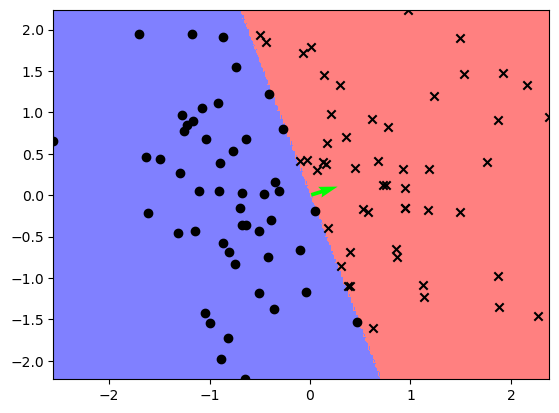

Training error: 0.0%


In [5]:
xTr,yTr=genrandomdata()
fun,w,b=primalSVM(xTr,yTr,C=10)
utils.visclassifier(fun,xTr,yTr,w=w,b=b)

err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

In [6]:
def testCase_Primal():
    Clocal = 1
    trainX = np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]]) 
    trainY = np.array([1,1,1,-1,1,1,-1,-1,1])
    fun_Primal,_,_ = primalSVM(trainX,trainY,C=Clocal)

    testX = np.array([[1.6,0.4],[1.4,1.6],[0.4,0.6],[0.4,1.6]])
    testY = np.array([-1,1,1,1])
    resultY = fun_Primal(testX)
    boolArray = (np.sign(resultY)==testY).tolist()
    signMatch = all(boolArray)
    return signMatch
print('primalSVM passes sign match test: ' + str(testCase_Primal()))

primalSVM passes sign match test: True


In [7]:
def updateboundary():
    global w,b,Xdata,ldata,stepsize

    _, w_pre, b_pre = primalSVM(np.transpose(Xdata),np.array(ldata),C=10)
    w = np.array(w_pre).reshape(-1)
    b = b_pre
    stepsize+=1

def updatescreen():
    global w,b,ax,line 
    q=-b/(w**2).sum()*w;
    if line==None:
        line, = ax.plot([q[0]-w[1],q[0]+w[1]],[q[1]+w[0],q[1]-w[0]],'b--')
    else:
        line.set_ydata([q[1]+w[0],q[1]-w[0]])
        line.set_xdata([q[0]-w[1],q[0]+w[1]])
    
def animate(i):
    #if len(ldata)>0 and ((min(ldata)+max(ldata))==0):
    if (len(ldata)>0) and ((np.min(ldata)+np.max(ldata))==0):
        if stepsize<1000:
            updateboundary()
            updatescreen();
    
def onclick(event):
    global Xdata, stepsize  
    if event.key == 'shift': # add positive point
        ax.plot(event.xdata,event.ydata,'or')
        label=1
    else: # add negative point
        ax.plot(event.xdata,event.ydata,'ob')
        label=-1    
    pos=np.array([[event.xdata],[event.ydata]])
    ldata.append(label);
    Xdata=np.hstack((Xdata,pos))
    stepsize=1;

Text(0.5, 1.0, 'Use shift-click to add negative points.')

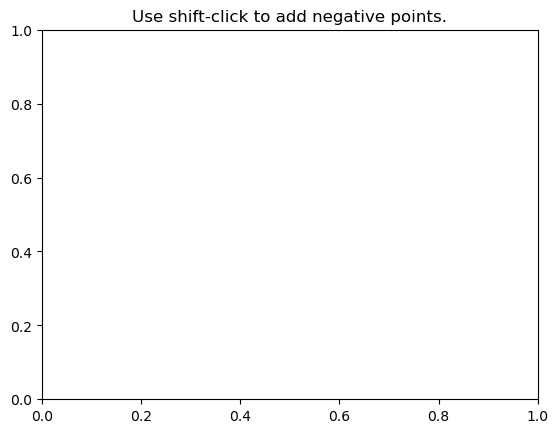

In [8]:
Xdata=np.random.rand(2,0)
ldata=[]
w=[]
b=[]
line=None
stepsize=1;
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
ani = FuncAnimation(fig, animate,np.arange(1,100,1),interval=10);
plt.title('Use shift-click to add negative points.')
# Note that it is easy to generate odd decision boundaries, particularly if data is not easily linearly separable

In [9]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

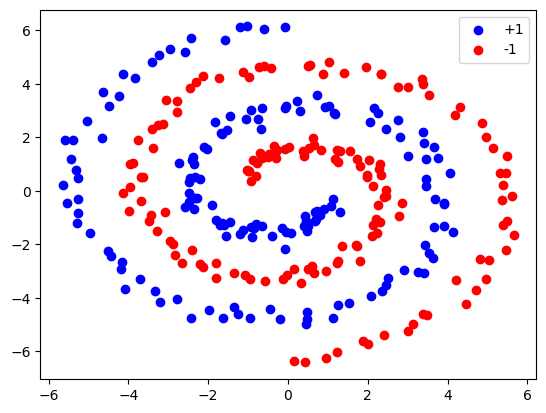

In [10]:
xTr,yTr,xTe,yTe=spiraldata()
fig = plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

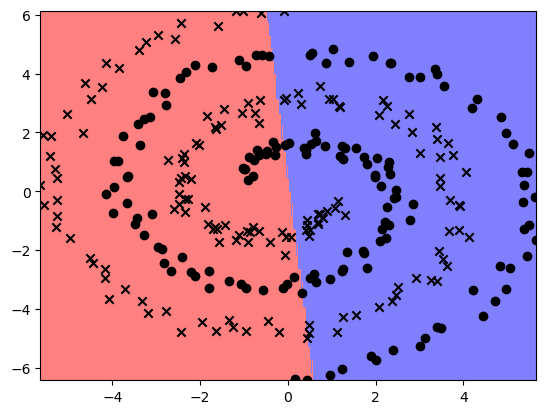

Training error: 40.7%


In [11]:
fun,w,b=primalSVM(xTr,yTr,C=0.01)
utils.visclassifier(fun,xTr,yTr,w=[],b=0)
err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

In [12]:
def computeK(kerneltype, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    def enforce_positive_definite(K, reg=1e-6):
        n = K.shape[0]
        if n == K.shape[1]:
            return K + reg * np.eye(n)
        else:
            return K
    
    if kerneltype == 'linear': 
        return enforce_positive_definite(X @ Z.T)
    elif kerneltype == 'rbf': 
        return enforce_positive_definite(np.exp(-kpar*np.sum((X[:, None, :] - Z)**2, axis=-1)))
    else: 
        return enforce_positive_definite(np.power(X @ Z.T + 1, kpar))

In [13]:
def isClose(num1,num2,numtol=1e-3):
    return np.abs(num1-num2)<numtol

def isMatClose(X1,X2,tol=1e-3):
    a,b = X1.shape
    output = True
    for i in range(a):
        for j in range(b):
            output = output and isClose(X1[i][j],X2[i][j],numtol=tol)
    return output 

def testCase_computeK_linear():
    X = np.array([[9],[0]])
    Z = np.array([[1],[3]])
    K = computeK('linear',X,Z)
    K = np.array(K)
    check = isMatClose(K,np.array([[9,27],[0,0]])) 
    return check

print('computeK passes test for linear kernel: ' + str(testCase_computeK_linear()))

computeK passes test for linear kernel: True


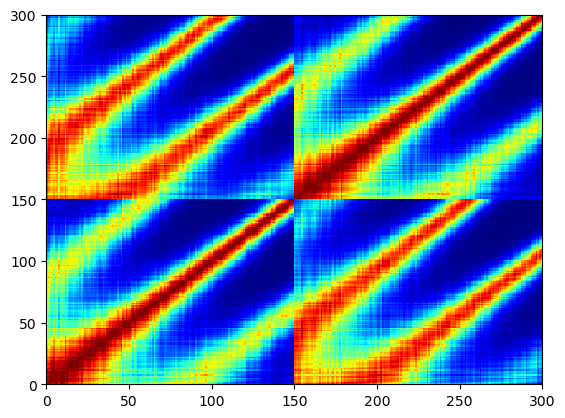

In [14]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
fig = plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

In [15]:
def dualqp(K,yTr,C):
    """
    function alpha = dualqp(K,yTr,C)
    constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        K     | the (nxn) kernel matrix
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
    
    Output:
        alpha | the calculated solution vector (nx1)
    """
    y = yTr.flatten()
    N, _ = K.shape
        
    slack = cvxpy.Variable(N)
    coeffs = cvxpy.multiply(slack, yTr)
    objective = (1/2) * cvxpy.quad_form(coeffs, K) - cvxpy.sum(slack)
    constraints = [cvxpy.sum(coeffs) == 0, 
                   0 <= slack,
                   slack <= C
                   ]
    
    problem = cvxpy.Problem(objective=cvxpy.Minimize(objective), 
                            constraints=constraints)
    problem.solve()

    return slack.value

In [16]:
C = 10
lmbda = 0.25
ktype = "rbf"
xTr,yTr,xTe,yTe=spiraldata()
# compute kernel (make sure it is PSD)
K = computeK(ktype,xTr,xTr)
eps = 1e-8
# make sure it is symmetric and positive semi-definite
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])

alpha = dualqp(K,yTr,C)

In [17]:
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : nx1 input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """
    idx = np.argmax(np.abs(C - alpha))
    return yTr[idx] - np.sum(yTr * alpha * K[:, idx])

    

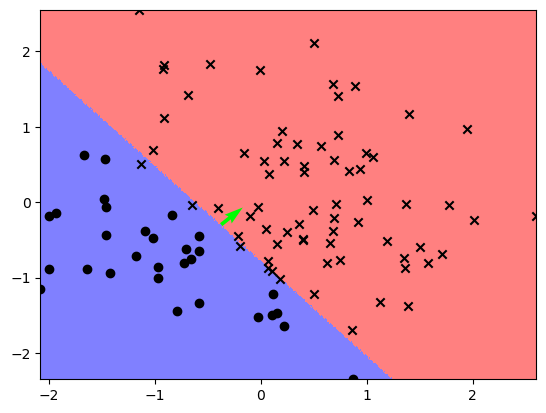

In [18]:
xTr,yTr=genrandomdata(b=0.5)
C=1
K=computeK("linear",xTr,xTr)
eps=1e-8
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
alpha = dualqp(K,yTr,C)
ba=recoverBias(K,yTr,alpha,C)
wa = (alpha * yTr).dot(xTr)
fun = lambda x: x.dot(wa) + ba
utils.visclassifier(fun, xTr, yTr, w=wa, b=ba)

In [19]:
def dualSVM(xTr,yTr,C,ktype,lmbda,eps=1e-8):
    """
    function classifier = dualSVM(xTr,yTr,C,ktype,lmbda);
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
        ktype | the type of kernelization: 'rbf','polynomial','linear'
        lmbda | the kernel parameter - degree for poly, inverse width for rbf
    
    Output:
        svmclassify | usage: predictions=svmclassify(xTe);
    """
    K = computeK(ktype, xTr, xTr, lmbda)
    K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
    alpha = dualqp(K, yTr, C)
    bias = recoverBias(K, yTr, alpha, C)
    weights = alpha * yTr
    
    def sexy_svm(X, weights=weights, bias=bias, lmbda=lmbda):
        return np.dot(weights, computeK(ktype, xTr, X, lmbda)) + bias
    
    return sexy_svm

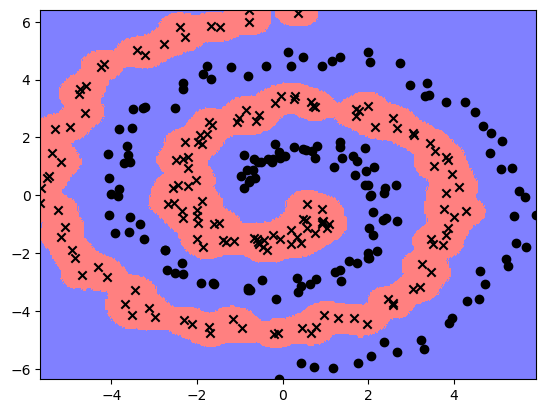

Training error: 0.0000
Testing error: 0.0133


In [20]:
xTr,yTr,xTe,yTe=spiraldata()
C=10.0
sigma=10.0 # Note: If sigma is too small you may get convergence errors.
ktype="rbf"
svmclassify=dualSVM(xTr,yTr,C,ktype,sigma)

utils.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

In [21]:
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    # gridsearch for best parameters
    
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.
    best_error = np.inf


    for i, C in enumerate(CList):
        for j, lm in enumerate(lmbdaList):
            K = computeK(ktype, xTr, xTr, lm)
            alpha = dualqp(K, yTr, C)
            weights = alpha * yTr
            bias = recoverBias(K, yTr, alpha, C)
            f = dualSVM(xTr, yTr, C, ktype, lm)
        
            error = np.mean((f(xValid) - yValid)**2)
            ErrorMatrix[i][j] = error

            if error < best_error:
                best_error, bestC, bestLmbda = error, C, lm
            
    
    return bestC, bestLmbda, ErrorMatrix

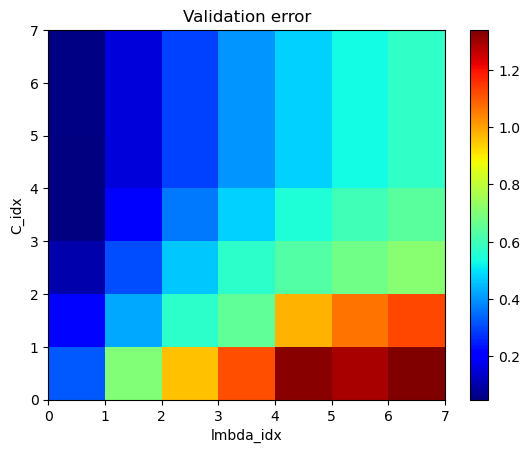

In [22]:
np.random.seed(15)
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-2,1,7))
lmbdaList=(np.linspace(1.0,15,7))

bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)
fig = plt.figure()
plt.pcolormesh(ErrorMatrix, cmap='jet')
plt.colorbar()
plt.xlabel("lmbda_idx")
plt.ylabel("C_idx")
plt.title("Validation error");

In [23]:
def train_test_split(X, y, train_proportion=0.75):
    n = X.shape[0]

    indices = np.random.permutation(n, )
    train_indices = indices[:int(train_proportion * n)]
    test_indices = indices[int(train_proportion * n):]

    return X[train_indices, :], y[train_indices], X[test_indices, :], y[test_indices]

def generate_noisy_data(N=1000):
    mean1 = [0, 0]
    cov1 = [[1, 0], [0, 1]]
    x1 = np.random.multivariate_normal(mean1, cov1, N)
    y1 = np.ones((N,))

    mean2 = [1, 1]
    cov2 = [[1, 0], [0, 1]]
    x2 = np.random.multivariate_normal(mean2, cov2, N)
    y2 = -np.ones((N,))

    return np.concatenate((x1, x2), axis=0), np.concatenate((y1, y2))

def generate_imbalanced_data(N=1000):
    n_features = 20
    weights = [0.1, 0.9]
    return np.random.randn(N, n_features), np.random.choice([0, 1], size=N, p=weights)

def generate_high_dim_data(N=1000):
    n_features = 100
    weights = [0.5, 0.5]
    return np.random.randn(N, n_features), np.random.choice([0, 1], size=N, p=weights)

def generate_spiral_data(N=1000):
    r = np.linspace(1,2*np.pi,N)
    X1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    X2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    X_final = np.concatenate([X1, X2], axis=0)
    y = np.concatenate([np.ones(N), -1 * np.ones(N)])
    X_final = X_final + np.random.randn(X_final.shape[0], X_final.shape[1])*0.2
    
    return X_final, y
    

In [57]:
def autosvm(xTr, yTr):
    
    n = len(yTr)
    xTr_copy, yTr_copy, xValid, yValid = train_test_split(xTr, yTr)
    
    mu_C, sigma_C = 4, 0.5
    mu_lmbda, sigma_lmbda = 10, 0.8
    best_error, bestC, bestLmbda = np.inf, np.inf, np.inf
    history_C, history_lmbda, history_error = [], [], []
    
    def is_pos_def(x):
        return np.all(np.linalg.eigvals(x) > 0)
    
    def error(C, lmbda): 
        K = computeK("rbf", xTr_copy, xTr_copy, lmbda)
        if is_pos_def(K):
            alpha = dualqp(K, yTr_copy, C)
            weights = alpha * yTr_copy
            bias = recoverBias(K, yTr_copy, alpha, C)
            f = dualSVM(xTr_copy, yTr_copy, C, "rbf", lmbda)

            return np.mean(np.sign(f(xValid))!=yValid)

        return 1
    
    j = 0
    for i in range(100):    
        C = np.random.normal(mu_C, sigma_C)
        lmbda = np.random.normal(mu_lmbda, sigma_lmbda)
        
        if C < 1 or lmbda < 7.5:
            continue
        
        error_proposal = error(C, lmbda)
        
        if error_proposal < best_error:
            print(f'* BEST * Iteration[{i+1}], C: {C}, Lambda: {lmbda}, Error: {error_proposal}')
            best_error = error_proposal
            sigma_C = sigma_C * 0.9**j
            sigma_lmbda = sigma_lmbda * 0.9**j
            mu_C = C
            mu_lmbda = lmbda
            j+= 1
            if best_error < 0.2:
                history_C.append(C)
                history_lmbda.append(lmbda)
                history_error.append(error_proposal)
                dualSVM(xTr, yTr, mu_C, ktype, mu_lmbda), history_C, history_lmbda, history_error
        
        history_C.append(C)
        history_lmbda.append(lmbda)
        history_error.append(error_proposal)
    
    return dualSVM(xTr, yTr, mu_C, ktype, mu_lmbda), history_C, history_lmbda, history_error


In [58]:
X, y = generate_noisy_data(N=200)
xTr, yTr, xTe, yTe = train_test_split(X,y)

svmclassify, C_list, LmDa_list, error_list = autosvm(xTr, yTr)
utils.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

ArpackNoConvergence: ARPACK error -1: No convergence (2251 iterations, 0/1 eigenvectors converged)

In [ ]:
import pandas as pd
df_mcmc = pd.DataFrame({'C' : C_list, 'Lambda' : LmDa_list, 'Error' : error_list})


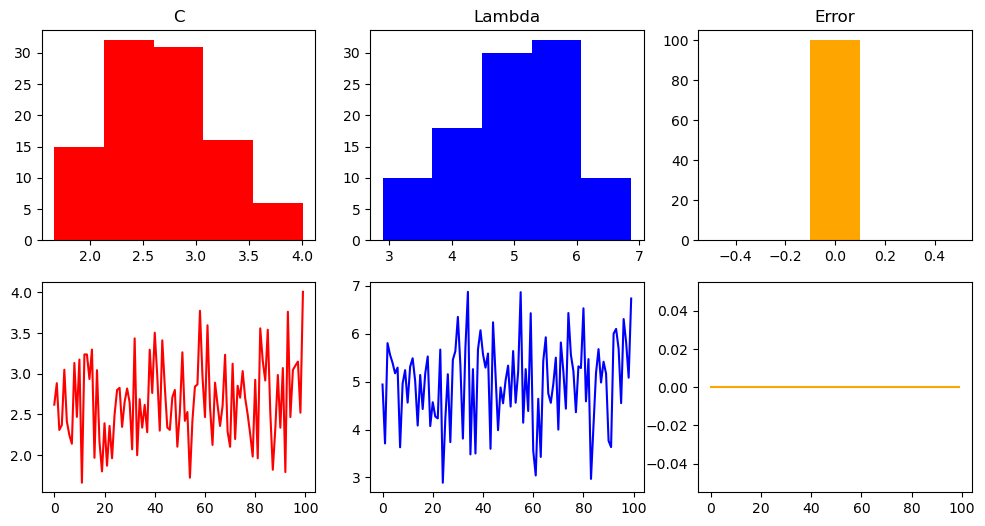

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (12, 6))
for i, c, col in zip(range(3), ['r', 'b', 'orange'], df_mcmc.columns):
    ax[0,i].hist(df_mcmc[col], color=c, bins=5)
    ax[1,i].plot(df_mcmc[col], color=c)
    ax[0,i].set_title(col)
